In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

from src.models_classical.utils import (
    under_over_sampler,
    scale_data,
    calculate_scores,
    collate_scores_binary_classification,
    get_classifier_and_params,
    get_model_metrics_df,
)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from src.visualization.visualize import plot_pr_roc_curves_kfolds

%load_ext autoreload
%autoreload 2

/home/tim/miniconda3/envs/arxiv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
proj_dir = Path().cwd().parent.parent
print(proj_dir)

path_emb_dir = proj_dir / "data" / "processed" / "embeddings"
path_model_dir = proj_dir / "models" / "final_results_classical" / "model_files"

/home/tim/Documents/arxiv-code-search


In [4]:
emb_file = "df_embeddings_other.pkl"
model_file = "model_14438904_rf_2022-06-08-0020-00_papers1.pkl"
scaler_file = "scaler_14438904_rf_2022-06-08-0020-00_papers1.pkl"

# load dfh.pickle
with open(path_emb_dir / emb_file, "rb") as f:
    df = pickle.load(f)

# load sklearn scaler from scaler file
with open(path_model_dir / scaler_file, "rb") as f:
    scaler = pickle.load(f)

# load the model
with open(path_model_dir / model_file, "rb") as f:
    model = pickle.load(f)

In [5]:
df.head()

,label,id,para,h
0,0,10.1016_j.ymssp.2015.05.028,"; q ðjþ; rðjþg and the observation set yn, a d...","[-0.6470553874969482, 0.6207976341247559, 0.05..."
1,0,10.1016_j.ymssp.2015.05.028,forward filtered data. therefore the smoothed ...,"[-0.513788640499115, 0.20524263381958008, -0.5..."
2,0,10.1016_j.ymssp.2016.04.028,the benchmark methods,"[-0.621538519859314, -0.34547579288482666, -0...."
3,0,10.1016_j.ymssp.2016.04.028,3.3. results comparison with a benchmark study,"[-0.5140003561973572, -0.8636043667793274, 0.2..."
4,0,10.1016_j.ymssp.2016.04.028,table 3 results comparison with the benchmark ...,"[-0.06085033714771271, -0.19399628043174744, 0..."


In [6]:
df["label"].unique()

array([0, 1])

In [11]:
# select only the papers with label == 1
df1 = df[df["label"] == 1]
df1.head()

,label,id,para,h
6,1,10.1016_j.ymssp.2016.04.028,"as in recent years, many new methods have been...","[-0.676788866519928, -2.4876792430877686, 0.09..."
0,1,10.1016_j.ymssp.2018.05.050,tamilselvan et al. proposed a multi-sensory db...,"[-0.11496513336896896, -0.22393637895584106, -..."
1,1,10.1016_j.ymssp.2018.05.050,networks for cutting states monitoring [98]. i...,"[-0.7092164754867554, -0.3423888683319092, -1...."
5,1,10.1016_j.ymssp.2018.05.050,2 please ﬁnd code and data inhttps://github.co...,"[-1.141634225845337, 0.6833096742630005, -0.14..."
15,1,10.1016_j.ymssp.2018.05.050,"in addition, the dataset and code have been pu...","[-0.437885046005249, -0.9807161688804626, 0.26..."


In [17]:
# print paragraphs
df1.iloc[2]["para"]

'networks for cutting states monitoring [98]. in the presented work, three different feature sets including raw vibration signal, mel-frequency cepstrum coefﬁcient (mfcc) and wavelet features were fed into dbn as three corresponding different inputs, which were able to achieve robust comparative performance on the raw vibration signal without too much feature engineering. tamilselvan et al. proposed a multi-sensory dbn-based health state classiﬁcation model. the model was veriﬁed in benchmark classiﬁcation problems and two health diagnosis applications including aircraft engine health diagnosis and electric power transformer health diagnosis [99,100]. tao et al. proposed a dbn based multisensor information fusion scheme for bearing fault diagnosis [101]. firstly, 14 time-domain statistical features extracted from three vibration signals acquired by three sensors were concatenated together as an input vector to the dbm model. during pre-training, a predeﬁned threshold value was introduc

In [7]:
x_test = np.array([e for e in df["h"].values])
y_test = df["label"].values
print(np.max(x_test))

x_test = scaler.transform(x_test)
print(np.max(x_test))

16.70672035217285
5.186684776765523


In [8]:
ind_score_dict = calculate_scores(model, x_test, y_test)

In [9]:
trained_result_dict = collate_scores_binary_classification([ind_score_dict])

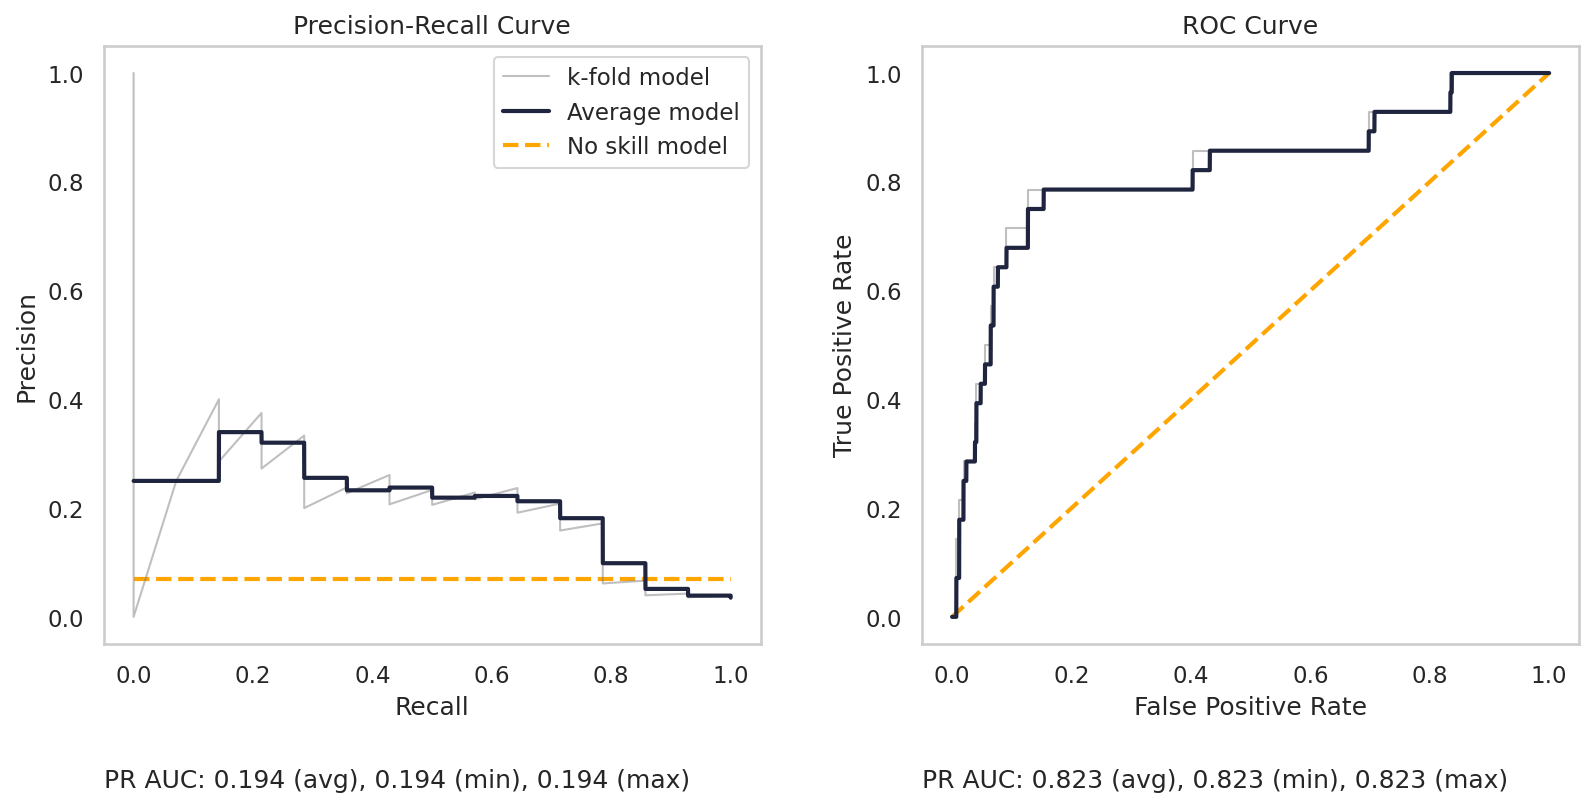

In [10]:
plot_pr_roc_curves_kfolds(
    trained_result_dict["precisions_array"],
    trained_result_dict["recalls_array"],
    trained_result_dict["fpr_array"],
    trained_result_dict["tpr_array"],
    trained_result_dict["rocauc_array"],
    trained_result_dict["prauc_array"],
    percent_anomalies_truth=0.07,
    save_plot=False,
    dpi=300,
)